<a href="https://colab.research.google.com/github/Dusein/MachineLearningTask/blob/main/6WeekTask/Clustering_Model_For_Online_Retail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

# Masukin path dataset
file_path = '/content/sample_data/Online Retail.xlsx'
retail_data = pd.read_excel(file_path)

retail_data



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [4]:
# Data preprocessing for clustering

# Hapus baris dengan CustomerID yang hilang karena sangat penting untuk segmentasi pelanggan
retail_data = retail_data.dropna(subset=['CustomerID']).copy()  # Menambahkan .copy() untuk menghindari SettingWithCopyWarning

# Ubah Tanggal Faktur menjadi tanggal waktu
retail_data.loc[:, 'InvoiceDate'] = pd.to_datetime(retail_data['InvoiceDate'])

# Hitung jumlah total yang dibelanjakan per transaksi
retail_data.loc[:, 'TotalAmount'] = retail_data['Quantity'] * retail_data['UnitPrice']


# Mengagregasi data untuk mendapatkan metrik RFM (Recency, Frequency, Monetary) untuk setiap pelanggan
# Baru-baru ini: Hari sejak pembelian terakhir
# Frekuensi: Jumlah transaksi
# Moneter: Total pengeluaran

# Tentukan tanggal referensi sebagai tanggal transaksi terakhir dalam dataset
reference_date = retail_data['InvoiceDate'].max()

# Aggregate data
rfm_data = retail_data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                     # Frequency
    'TotalAmount': 'sum'                                        # Monetary
}).rename(columns={'InvoiceDate': 'Recency',
                   'InvoiceNo': 'Frequency',
                   'TotalAmount': 'Monetary'})

# Menampilkan beberapa baris pertama dari data RFM
rfm_data.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,2,0.00
12347.0,1,7,4310.00
12348.0,74,4,1797.24
12349.0,18,1,1757.55
12350.0,309,1,334.40


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Skala data RFM untuk kinerja pengelompokan yang lebih baik
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data)

# Sesuaikan model K-Means
# Memilih jumlah cluster secara acak, katakanlah 4, untuk pengujian awal
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_data['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Menampilkan data RFM yang dikelompokkan dengan penetapan cluster
rfm_data.head()


,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,325,2,0.00,1
12347.0,1,7,4310.00,3
12348.0,74,4,1797.24,3
12349.0,18,1,1757.55,3
12350.0,309,1,334.40,1


In [24]:
from sklearn.decomposition import PCA

# Tentukan jumlah cluster optimal (misal: 4, bisa disesuaikan berdasarkan elbow atau silhouette)
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm_data['Cluster'] = kmeans.fit_predict(data_scaled)

# PCA untuk mereduksi data ke 2 dimensi untuk visualisasi
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data_scaled)

# Membuat DataFrame untuk visualisasi
visual_df = pd.DataFrame(data_2d, columns=['PCA1', 'PCA2'])
visual_df['Cluster'] = rfm_data['Cluster']


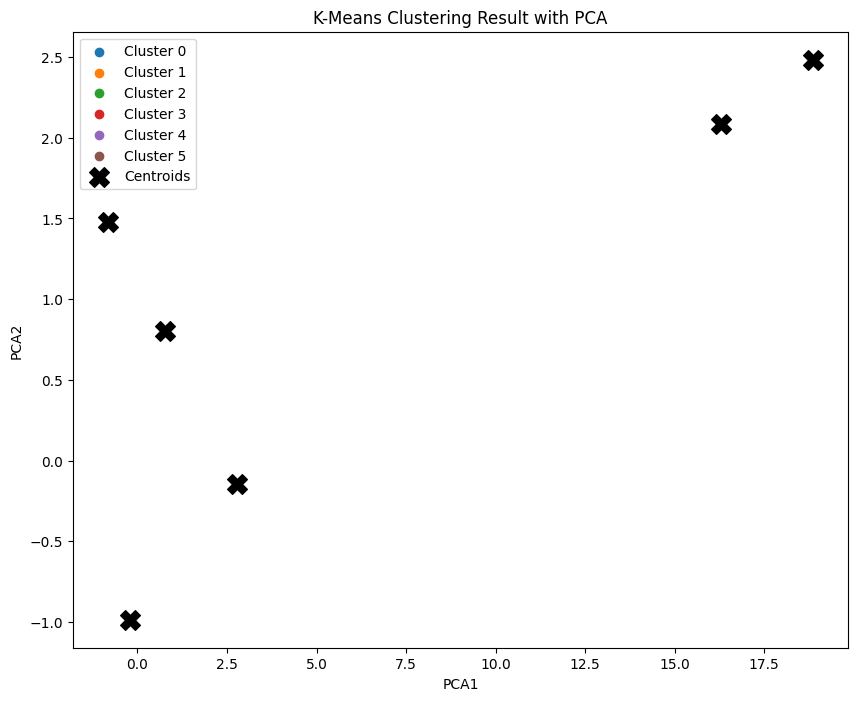

In [25]:
plt.figure(figsize=(10, 8))

# Buat scatter plot untuk setiap cluster
for cluster in range(optimal_k):
    cluster_data = visual_df[visual_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')

# Tambahkan centroid ke dalam plot
centroids_2d = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], s=200, c='black', marker='X', label='Centroids')

# Tambahkan detail visualisasi
plt.title("K-Means Clustering Result with PCA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.show()


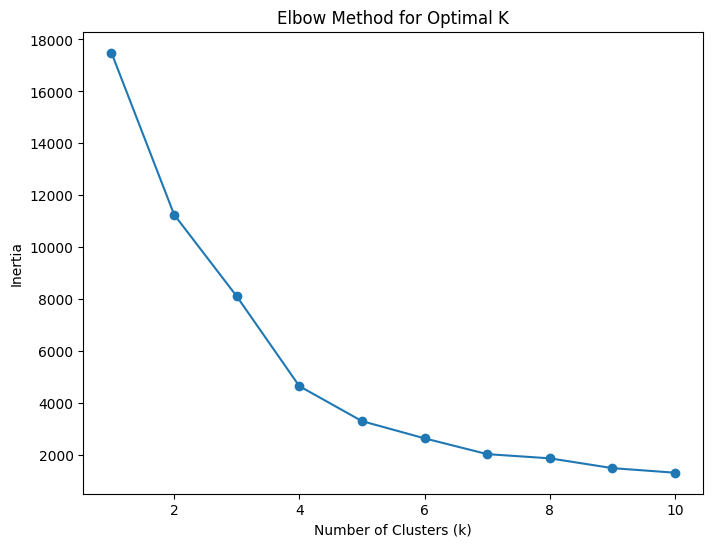

In [26]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Normalisasi data RFM jika belum dilakukan
scaler = StandardScaler()
data_scaled = scaler.fit_transform(rfm_data)

# Menghitung inertia untuk berbagai jumlah cluster
inertias = []
cluster_range = range(1, 11)  # Coba cluster dari 1 hingga 10
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertias.append(kmeans.inertia_)

# Visualisasi elbow plot
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertias, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()


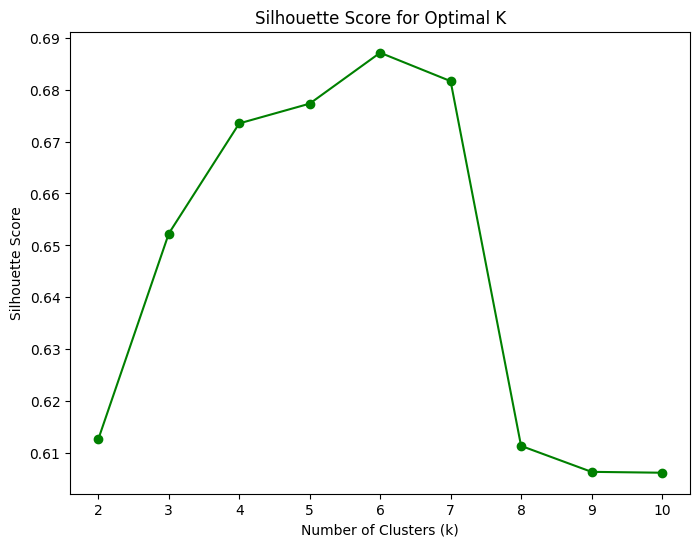

Silhouette Scores: [0.6126862880569258, 0.6522821807265887, 0.6734973751609746, 0.677303947883069, 0.6871092737416112, 0.6816366253703361, 0.6113893673669579, 0.6063891112328649, 0.6062203492064056]


In [27]:
from sklearn.metrics import silhouette_score

# Menghitung silhouette score untuk berbagai jumlah cluster
silhouette_scores = []
for k in cluster_range[1:]:  # Dimulai dari 2, karena silhouette tidak relevan untuk 1 cluster
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(data_scaled, labels))

# Visualisasi silhouette score
plt.figure(figsize=(8, 6))
plt.plot(cluster_range[1:], silhouette_scores, marker='o', color='green')
plt.title("Silhouette Score for Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()
print("Silhouette Scores:", silhouette_scores)

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

# Normalisasi data RFM atau data yang akan di-cluster jika belum dilakukan
scaler = StandardScaler()
data_scaled = scaler.fit_transform(rfm_data)

# Melatih model K-Means dengan jumlah cluster yang optimal (misalnya 4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(data_scaled)

# Menghitung Calinski-Harabasz Index
ch_score = calinski_harabasz_score(data_scaled, labels)
print("Calinski-Harabasz Index:", ch_score)


Calinski-Harabasz Index: 4009.6249796521115


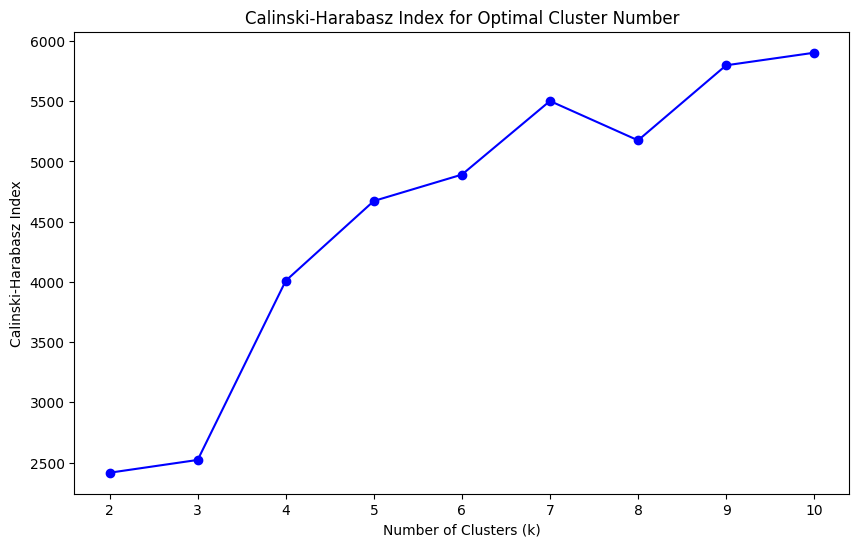

Calinski-Harabasz Index: [2416.0679634937233, 2522.2087070419907, 4009.6249796521115, 4671.510659322913, 4890.356403410808, 5501.385451743879, 5174.693749724605, 5797.552540301643, 5901.959055134926]


In [29]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

# Normalisasi data jika belum dilakukan
scaler = StandardScaler()
data_scaled = scaler.fit_transform(rfm_data)

# Menghitung Calinski-Harabasz Index untuk berbagai jumlah cluster
ch_scores = []
cluster_range = range(2, 11)  # Coba cluster dari 2 hingga 10
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_scaled)
    ch_score = calinski_harabasz_score(data_scaled, labels)
    ch_scores.append(ch_score)

# Visualisasi Calinski-Harabasz Index
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, ch_scores, marker='o', color='blue')
plt.title("Calinski-Harabasz Index for Optimal Cluster Number")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Calinski-Harabasz Index")
plt.show()
print("Calinski-Harabasz Index:", ch_scores)